<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Feature Engineering and Model Training  </h1>



The dataset spans from **April 2, 2025** to **April 4, 2025**, based on the assumption that mid-2025 trade tensions lead to an increase in abnormal or suspicious transaction activities.

For **Feature Engineering**, we handled numerical and categorical variables separately with the following steps: 

- Handle missing values.

- Create new features.

- Apply feature transformations.



In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

In [37]:
df = pd.read_csv('data/EDA_transaction_monitoring_merged.csv')

In [38]:
df.head().T

,0,1,2,3,4
customer_id,CUST00861,CUST00140,CUST00155,CUST00650,CUST00039
transaction_id,9297eaac-fcc2-4d18-92ae-f13c963bd564,624b31d7-2e5c-48ad-97c6-eb3ccb5a1c0e,534234cf-1974-4b71-a00f-7ed09248c8c8,64cfd9b9-050e-4961-b363-d272d0181ce6,89fab5cc-95b0-4f8a-964f-10b584d6b400
currency,DKK,EUR,EUR,EUR,NOK
transaction_date,2025-04-03 21:35:23,2025-04-03 03:23:40,2025-04-02 13:37:28,2025-04-03 13:35:46,2025-04-02 19:09:23
value_date,2025-04-03 21:35:23,2025-04-03 03:23:40,2025-04-04 13:37:28,2025-04-05 13:35:46,2025-04-04 19:09:23
payment_date,2025-04-05 21:35:23,2025-04-05 03:23:40,2025-04-05 13:37:28,2025-04-07 13:35:46,2025-04-05 19:09:23
booking_date,2025-04-07 21:35:23,2025-04-05 03:23:40,2025-04-06 13:37:28,2025-04-07 13:35:46,2025-04-07 19:09:23
type_description,Insättning,Insättning,Överföring,Kortköp,Överföring
transaction_type,deposit,deposit,transfer,card,transfer
narrative,Deposit from Jönsson AB,Deposit from Solberg og Sønner,Transfer to Solheim-Knudsen,Card payment at Sjögren & Olsson AB,Transfer to Danielsen & Søn ApS


## <h2 style="font-size: 1.8em; font-weight: bold;"> Feature Engineering </h2>

## <h3 style="font-size: 1.6em; font-weight: bold;"> 1. Handling Missing Values </h2>

In [39]:
#First, start with categorical features.
feature_na = [feature for feature in df.columns 
              if df[feature].isnull().sum()>1]
feature_na

['card_number', 'message', 'own_message']

As discovered in the EDA, most of the columns with missing values are categorical, so we will replace them with a new label, 'missing'.

In [40]:
#Drop or fill with 0 for columns that show no meaningful correlation with the target variable.
for feature in feature_na: 
  df[feature_na] = df[feature_na].fillna ('missing') 

In [41]:
df.isnull().sum().unique()

array([0], dtype=int64)

In this project, there are no missing numeric values. But if there were, we’d use the median or mode to fill them in, since we found outliers during EDA.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. New Features Creation </h2>

**Numeric Features**

In [42]:
continuous_features = df.select_dtypes(include=['float']).columns.to_list()
continuous_features 

['amount_eur',
 'available_balance_eur',
 'value_dated_balance_eur',
 'credit_limit_eur',
 'total_volume_eur',
 'avg_amount_eur',
 'max_amount_eur',
 'min_amount_eur']

Globally compare patterns (across all transactions).

In [43]:
global_txn_amount = df['amount_eur'].median()
df['is_txn_above'] = (df['amount_eur'] > global_txn_amount).astype(int)

total_txn_amount = df['total_volume_eur'].median()
df['is_total_txn_above'] = (df['total_volume_eur'] > total_txn_amount).astype(int)

Local Analysis. 

In [44]:
df['balance_use_pct'] = round(df['amount_eur'] *100.00 / df['value_dated_balance_eur'],2) 
df['limit_use_pct'] = round(df['amount_eur']*100.00 / df['credit_limit_eur'],2) 
df['is_above_max'] = ((df['amount_eur'] - df['max_amount_eur']) >0 ).astype(int)                
df['is_below_min'] = ((df['amount_eur'] - df['min_amount_eur']) < 0 ).astype(int)  
df['is_above_avg'] = ((df['amount_eur'] - df['avg_amount_eur']) >0 ).astype(int)      

**Temporal Features (Datetime)**

In [45]:
df.rename(columns= {'latest_transaction_booking_date': 'last_booking_date'}, inplace=True)

In [46]:
from pandas.api.types import is_datetime64_any_dtype

date_col = []
new_col = []
for col in df.columns: 
    if df[col].dtypes=='O':
      try:
         convert = pd.to_datetime(df[col])
         if is_datetime64_any_dtype(convert):
            if col !='dob':
             new_col = col+'time'
             df.rename(columns= {col:new_col},inplace=True)
             date_col.append(new_col)
      except Exception: 
         continue
print (date_col)

['transaction_datetime', 'value_datetime', 'payment_datetime', 'booking_datetime', 'last_booking_datetime', 'last_transaction_datetime']


In [47]:
new_date_col = []
for col in date_col[:]:
    df[col] = pd.to_datetime(df[col])
    if col != 'dob':
      df[col + '_day'] = df[col].dt.day
      df[col + '_weekday'] = df[col].dt.day_of_week
      df[col + '_hour'] = df[col].dt.hour
      new_date_col.extend([col + '_day', col + '_weekday', col + '_hour'])

print(new_date_col)

['transaction_datetime_day', 'transaction_datetime_weekday', 'transaction_datetime_hour', 'value_datetime_day', 'value_datetime_weekday', 'value_datetime_hour', 'payment_datetime_day', 'payment_datetime_weekday', 'payment_datetime_hour', 'booking_datetime_day', 'booking_datetime_weekday', 'booking_datetime_hour', 'last_booking_datetime_day', 'last_booking_datetime_weekday', 'last_booking_datetime_hour', 'last_transaction_datetime_day', 'last_transaction_datetime_weekday', 'last_transaction_datetime_hour']


`age`

In [48]:
from datetime import datetime
df['dob'] = pd.to_datetime(df['dob'])
today = datetime.today()
df['age'] = (
    today.year - df['dob'].dt.year -
    ((df['dob'].dt.month > today.month) | 
     ((df['dob'].dt.month == today.month) & (df['dob'].dt.day > today.day)))
)

`split_payment`

To flag `split_payment`, we applied business rules to identify accounts that show any of these signs:

- Made multiple payments within a single day.

- Had repeated or similar transaction amounts

- Made more than a set number of payments (high frequency).

In [49]:
# Case 1: Made multiple payments within a single day
time_diff = df.groupby('customer_id')['transaction_datetime'].diff()
df['is_sequential']= (time_diff <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
df['is_repeated_amount'] = df.groupby('customer_id')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
df['is_high_frequency'] = (df['transaction_count'] >= 10).astype(int)

In [50]:
count_is_sequential = df['is_sequential'].value_counts()
count_is_repeated_amount = df['is_repeated_amount'].value_counts()
count_is_high_frequency = df['is_high_frequency'].value_counts()

print (count_is_sequential, count_is_repeated_amount,count_is_high_frequency)

is_sequential
1    8458
0    2151
Name: count, dtype: int64 is_repeated_amount
0    10609
Name: count, dtype: int64 is_high_frequency
1    7846
0    2763
Name: count, dtype: int64


It seems that we don't have any transactions with repeated amounts, so we should drop this feature as it adds no weight to our model.

In [51]:
df.drop(columns='is_repeated_amount', inplace=True)

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. Feature Transformation </h2>

**3.1 Continuous Variable**

In [52]:
continuous_feature = df.select_dtypes(include='float').columns.to_list()
print(continuous_feature)

['amount_eur', 'available_balance_eur', 'value_dated_balance_eur', 'credit_limit_eur', 'total_volume_eur', 'avg_amount_eur', 'max_amount_eur', 'min_amount_eur', 'balance_use_pct', 'limit_use_pct']


As discovered during EDA, most numerical variables are skewed and require transformation.

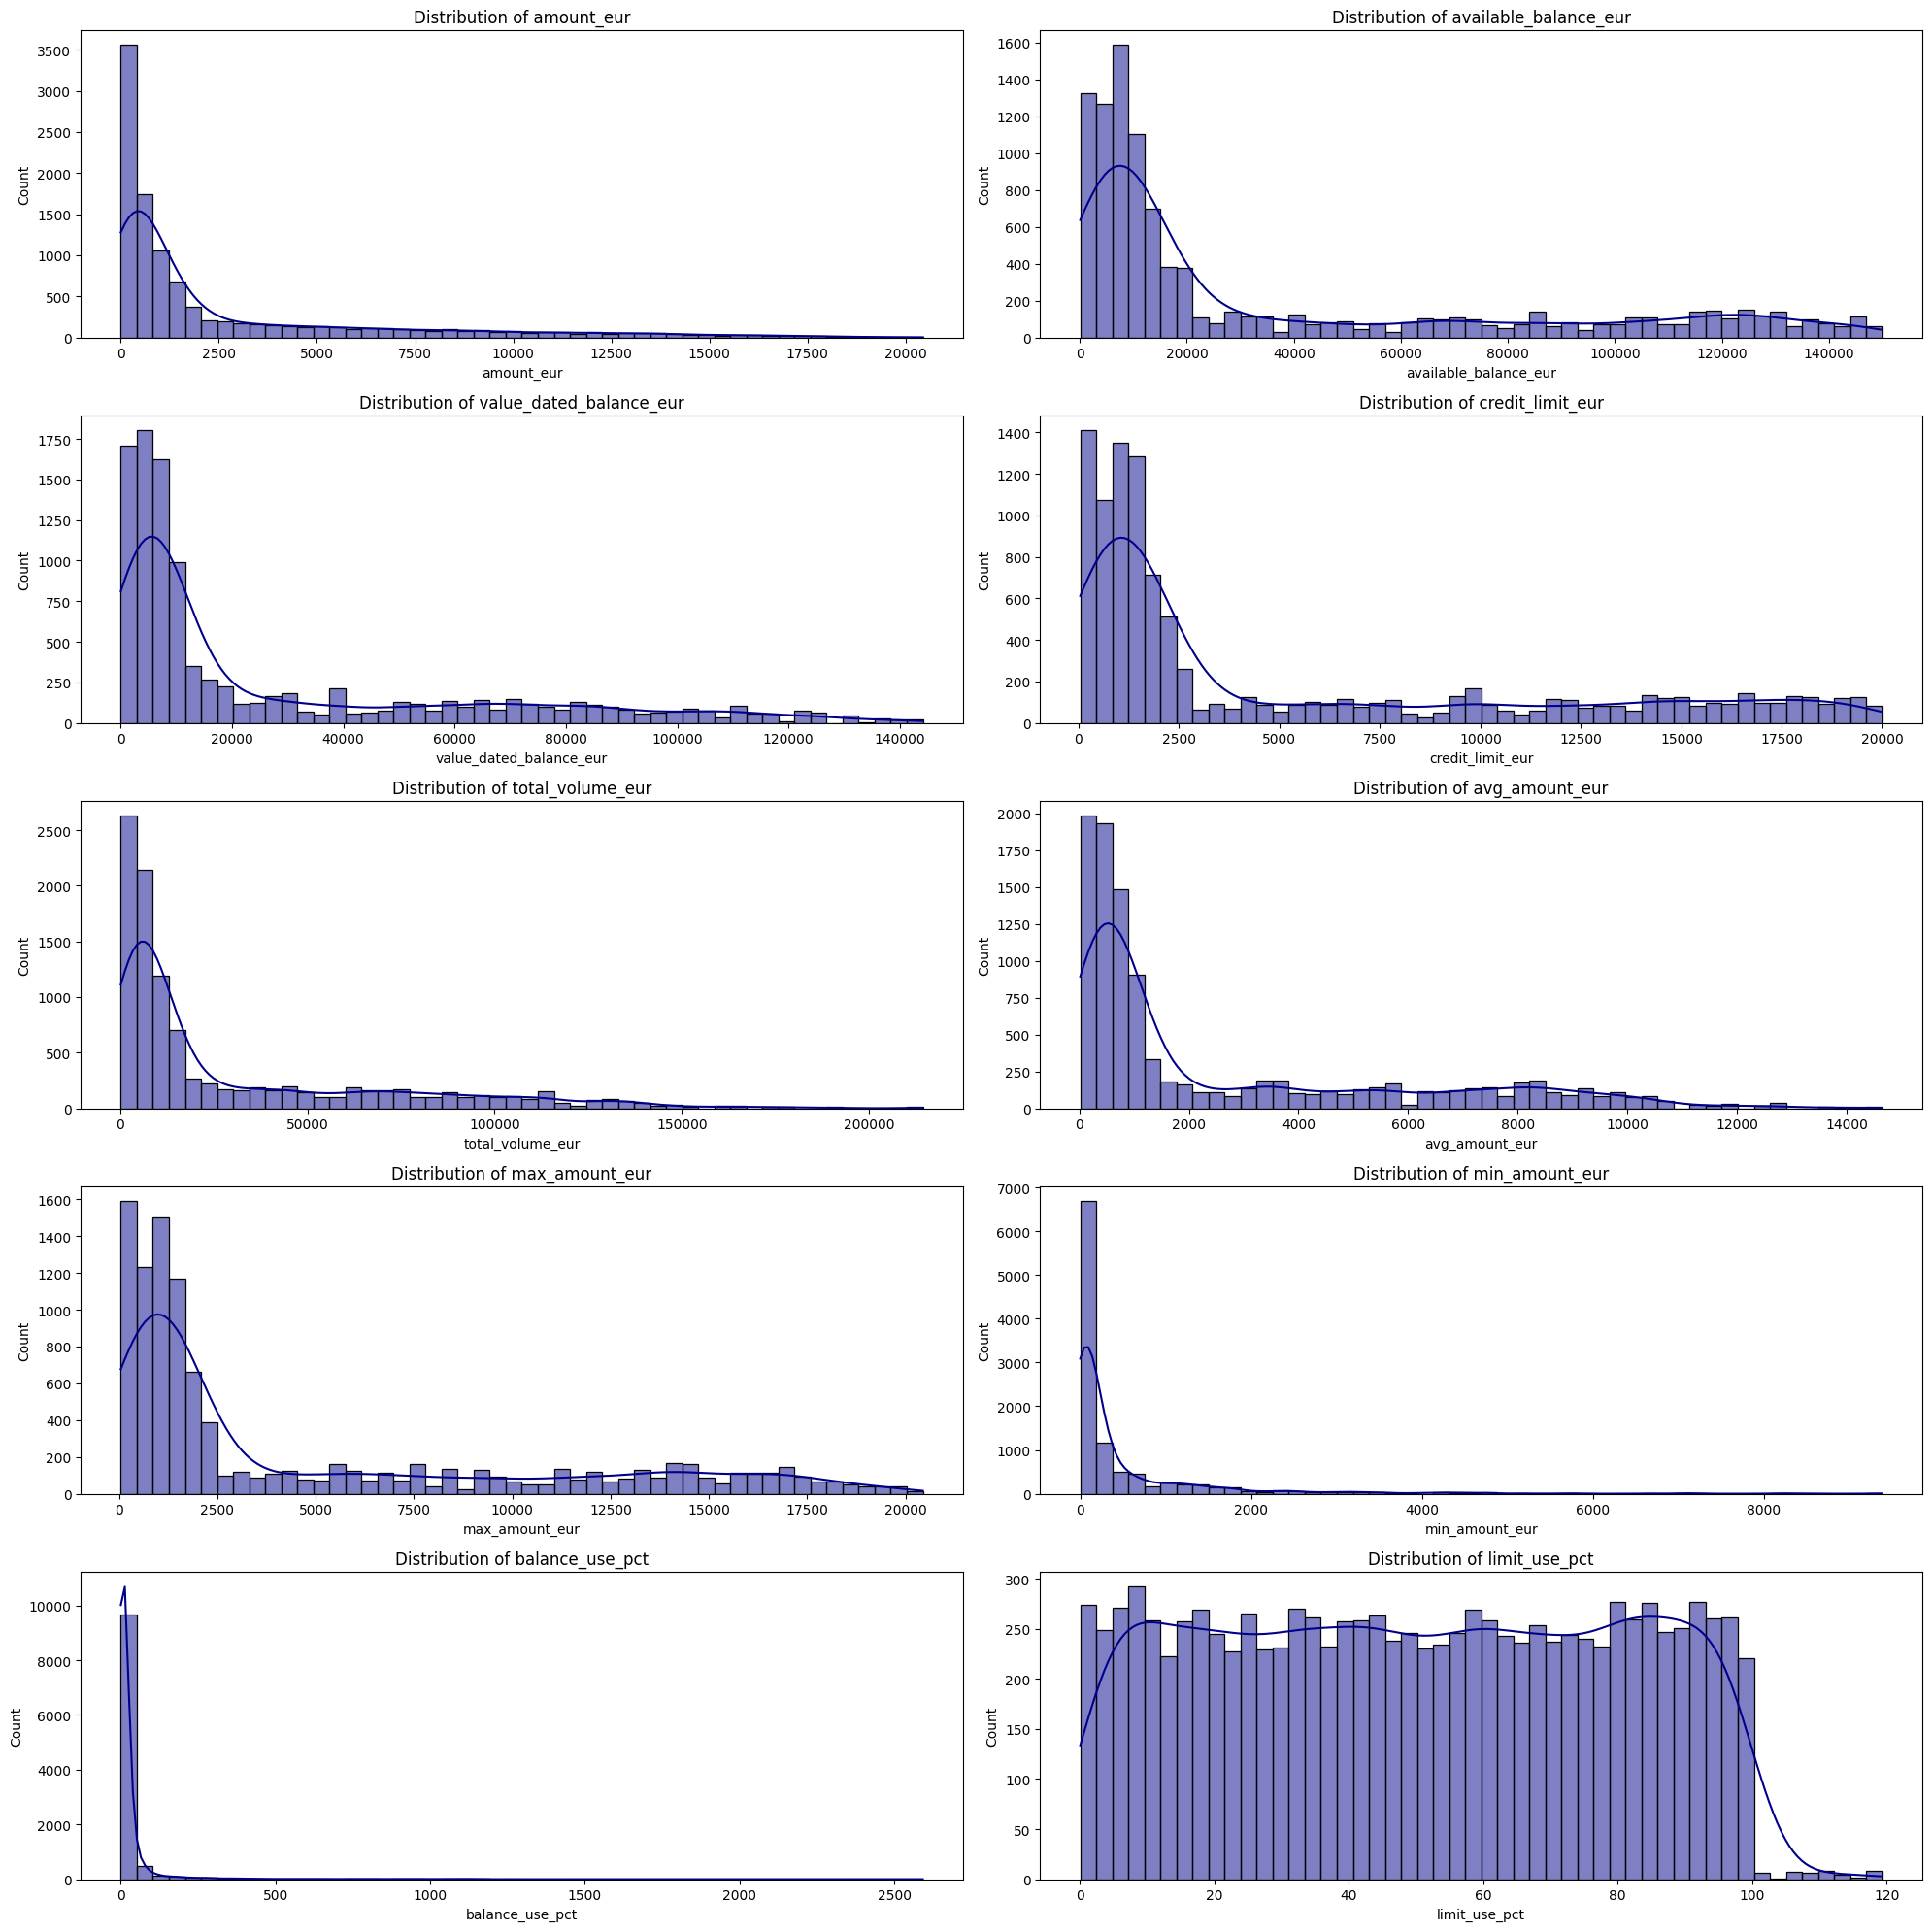

In [53]:
plt.figure(figsize=(20, 20))
for i, col in enumerate(continuous_feature,1):
      df_copy = df.copy()
      plt.subplot(5, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

Let's apply log transformation.

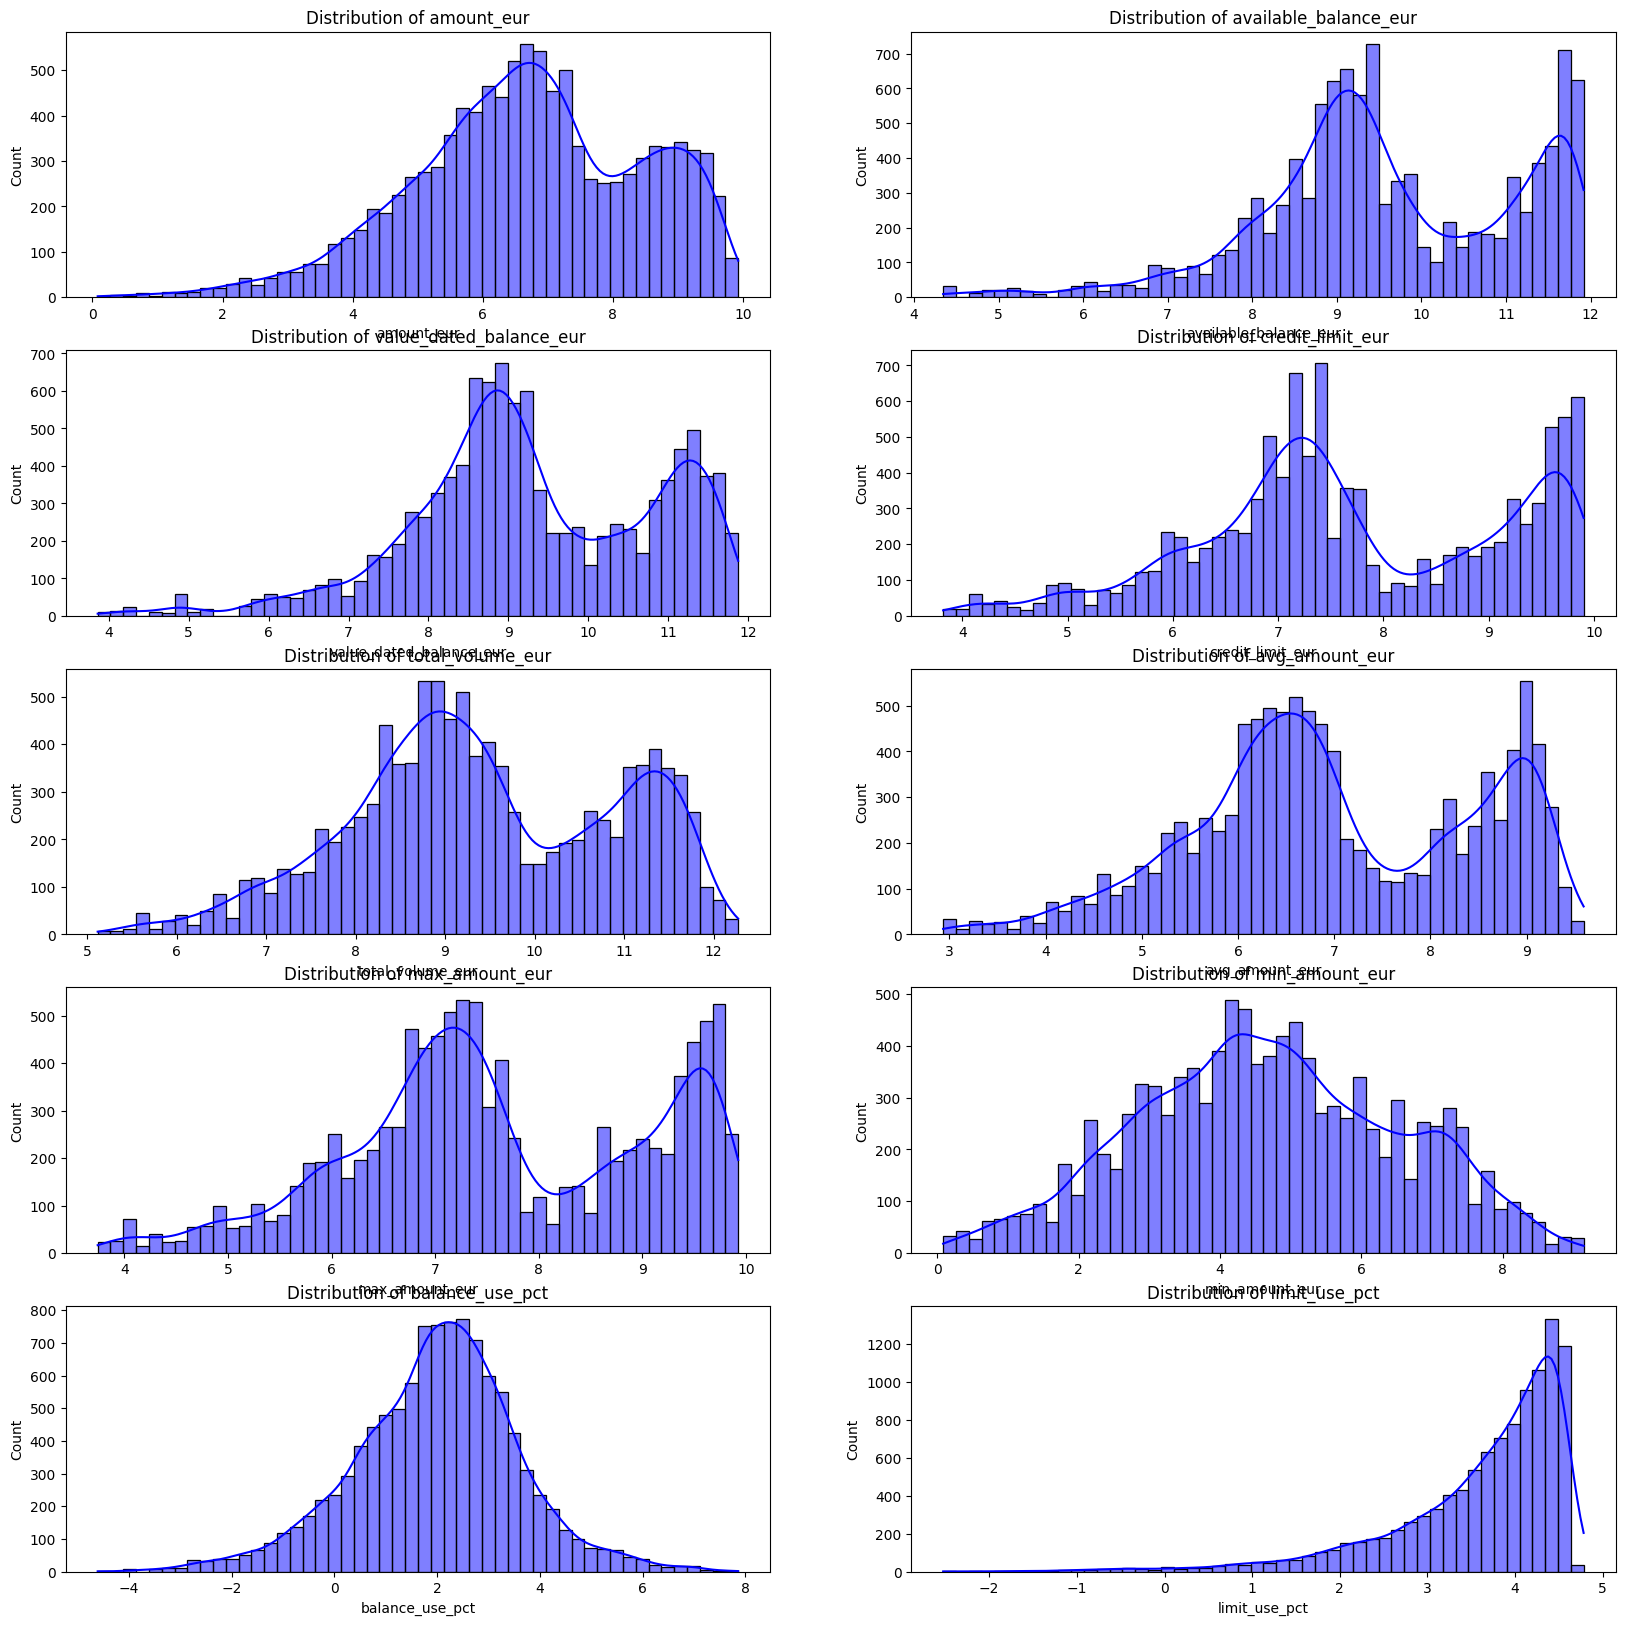

In [54]:

from numpy import log

plt.figure(figsize=(20, 20))
for i, col in enumerate(continuous_feature,1):
    df_copy=df.copy()
    if 0 in df_copy[col].unique():
        pass
    else:
       df_copy[col] = np.log(df_copy[col])
       plt.subplot(5, 2, i)
       sns.histplot(df_copy[col], bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

 

Let's try applying the Box-Cox transformation.

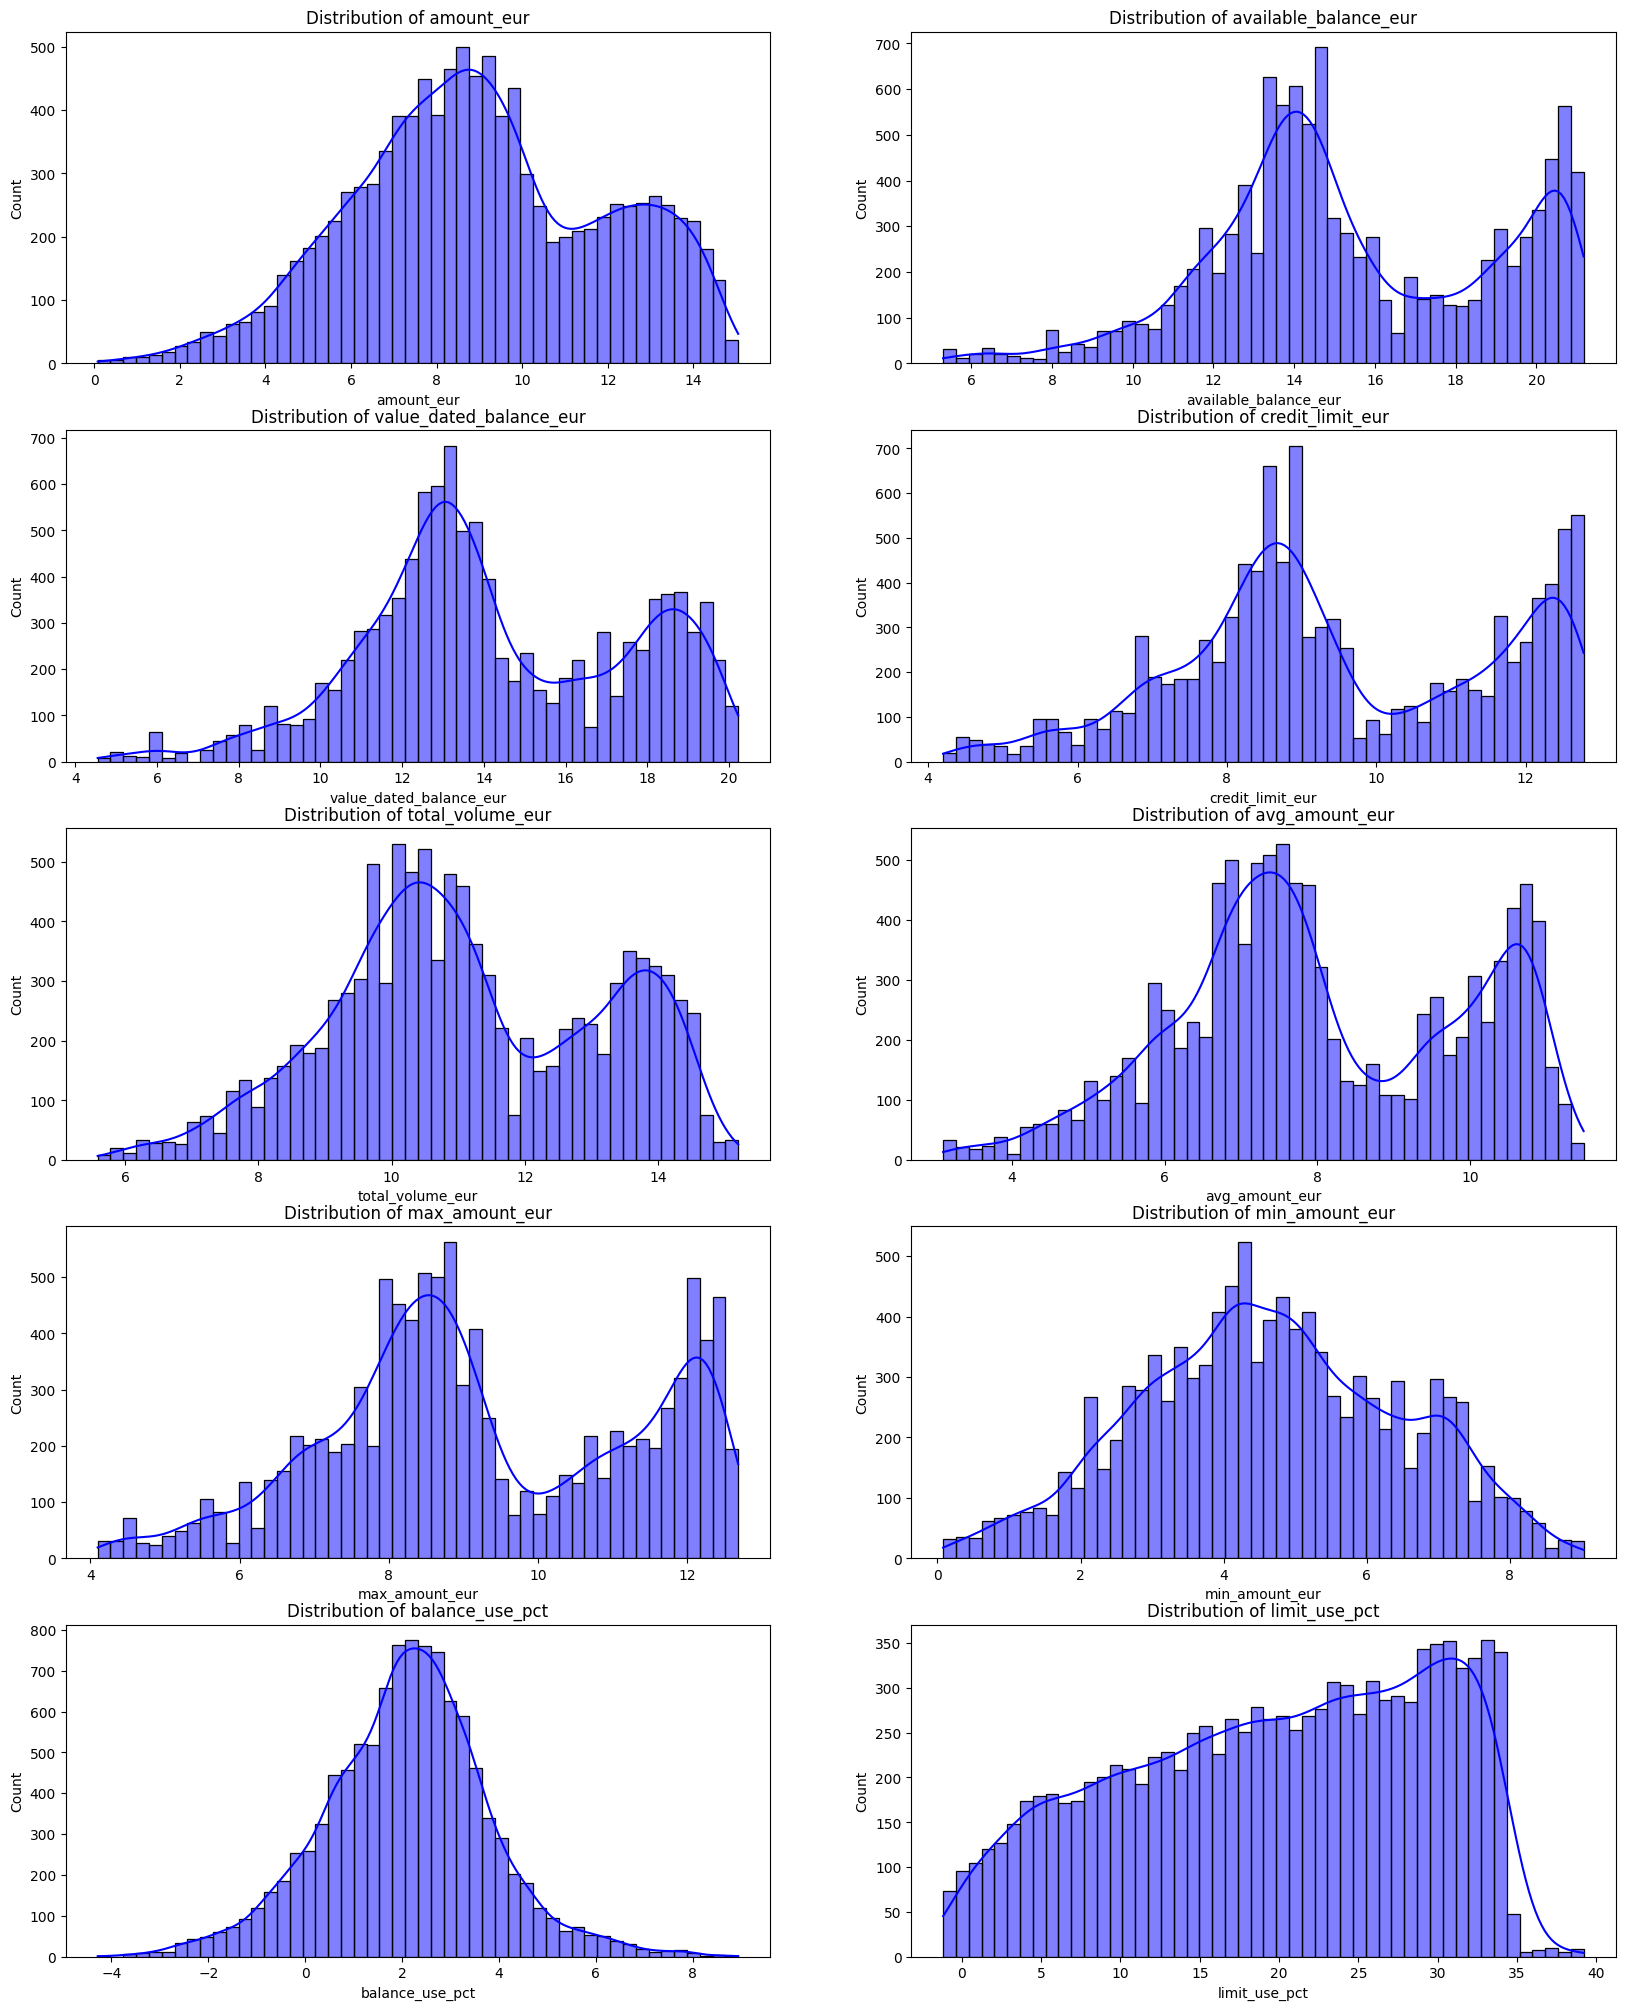

In [55]:
from scipy.stats import boxcox

plt.figure(figsize=(20, 25))
for i, col in enumerate(continuous_feature,1):
    if 0 in df[col].unique():
        pass
    else:
       bc_result,_ = boxcox(df[col])
       plt.subplot(5, 2, i)
       sns.histplot(bc_result, bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

It seems there isn’t much difference when applying Box-Cox or log transformation to our dataset, except for `limit_use_pct`, which shows better results

**3.2 Categorical Feature**

In [56]:
categorical_feature = df.select_dtypes(include='object').columns.to_list()

#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_feature: 
    count_value = df[feature].value_counts()
    print (feature,'-', len(count_value),'categories')


customer_id - 1000 categories
transaction_id - 10609 categories
currency - 4 categories
type_description - 5 categories
transaction_type - 5 categories
narrative - 9796 categories
status_x - 1 categories
counterparty_name - 8373 categories
card_number - 2085 categories
message - 2 categories
own_message - 2 categories
country - 5 categories
account_numbers - 1000 categories
account_name - 997 categories
product - 3 categories
account_type - 2 categories
status_y - 1 categories
registration_number - 1000 categories
residence_country - 5 categories
occupation - 10 categories
gender - 3 categories
bank.name - 1 categories
bank.bic - 1 categories
bank.country - 5 categories


In [57]:
drop_col = []
date_col = ['transaction_date', 'booking_date', 'value_date', 'payment_date']
for feature in categorical_feature: 
    count_value = df[feature].value_counts() 
    if len(count_value) >= 900 or len (count_value) == 1:
      drop_col.append(feature)
    if feature in date_col:
      drop_col.append(feature)
print(drop_col)

['customer_id', 'transaction_id', 'narrative', 'status_x', 'counterparty_name', 'card_number', 'account_numbers', 'account_name', 'status_y', 'registration_number', 'bank.name', 'bank.bic']


In [58]:
categorical_feature = [col for col in categorical_feature if col not in drop_col]

*Rare Categorical Feature*

We will lable 'rare_var' for categorical variables that appear in less than 1% of the observations, as they carry little significance for the analysis.

In [59]:
for feature in categorical_feature:
      counts = df[feature].value_counts()
      rare_categories = counts[counts < len(df) * 0.01].index
      df[feature] = df[feature].apply(lambda x: 'rare_var' if x in rare_categories else x)

In [60]:
df[categorical_feature].nunique()

currency              4
type_description      5
transaction_type      5
message               2
own_message           2
country               5
product               3
account_type          2
residence_country     5
occupation           10
gender                3
bank.country          5
dtype: int64

In [61]:
#high_card_feature = []
#for feature in categorical_features: 
    #if feature not in drop_col:
     #count_value = categorical_features[feature].value_counts()
     #if len(count_value) > 10:
       #high_card_feature.append(feature)


In [62]:
##for feature in high_card_feature:
      #labels_ordered = df.groupby([feature])['is_fraud'].mean().sort_values().index
      #labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
      #df[feature] = df[feature].map(labels_ordered)
#df[high_card_feature].nunique()

In [63]:
#from sklearn.model_selection import KFold

#from sklearn.model_selection import KFold

#kf = KFold(n_splits=5, shuffle=True, random_state=42)

#for feature in high_card_feature:
    #if feature not in drop_col:
        #df[feature] = np.nan  # clear column to store encoded values

        #for train_idx, val_idx in kf.split(df):
            #means = df.iloc[train_idx].groupby(feature)['is_fraud'].mean()
            #df.loc[df.index[val_idx], feature] = df.loc[df.index[val_idx], feature].map(means)

        #df[feature].fillna(df['is_fraud'].mean(), inplace=True)

#df[high_card_feature].nunique()


In [64]:
#Collect high-cardinality features that have no relationship with is_fraud into a drop list
#for feature in high_card_feature:
  #if df[feature].nunique() == 1 and df[feature].unique()[0] == 0:
        #drop_col.append(feature)
#print(drop_col)

**3.3 Final Transformation**

- For Continuous features, as they contain outliers, we will use RobustScaler() for feature scalling. 

- For categorical features, after eliminating rare values, we will apply one-hot encoding.

In [65]:
df[categorical_feature] = df[categorical_feature].astype(str)

In [66]:
datetime_col = df.select_dtypes(include='datetime').columns.to_list()

In [67]:
numeric_feature = df.select_dtypes(include=['float', 'int']).columns.to_list()

In [71]:
print(len(categorical_feature), len(numeric_feature), len(datetime_col), len(drop_col))

12 38 7 12


In [70]:
df.shape

(10609, 69)

In [72]:
drop_col.extend(datetime_col)

In [73]:
df.drop(columns=drop_col, inplace=True)

In [74]:
df.shape

(10609, 50)

In [75]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_feature),
        ('num', numerical_transformer, numeric_feature)
    ],
    remainder='passthrough' 
)

df_processed = preprocessor.fit_transform(df)

feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feature)) 
feature_names.extend(numeric_feature)
data = pd.DataFrame(df_processed, columns=feature_names)


In [76]:
col = [col for col in data.columns if col != 'is_fraud'] + ['is_fraud']
data = data[col]
data.head().T

,0,1,2,3,4
currency_DKK,1.000000,0.000000,0.0,0.000000,0.000000
currency_EUR,0.000000,1.000000,1.0,1.000000,0.000000
currency_NOK,0.000000,0.000000,0.0,0.000000,1.000000
currency_SEK,0.000000,0.000000,0.0,0.000000,0.000000
type_description_Autogiro,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...
last_transaction_datetime_hour,0.250000,-0.250000,0.5,-0.500000,0.500000
age,-0.827586,0.172414,-1.0,0.896552,0.448276
is_sequential,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
is_high_frequency,0.000000,-1.000000,0.0,0.000000,0.000000


Save a clean dataset with the target variable is_fraud as the first column.

In [77]:
data.to_csv('data/CLEAN_nordic_transactions_with_fraud.csv', index=False)